In [39]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [41]:
df = pd.read_csv('../dataset/GOOG2020.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-01,1265.000000,1274.619995,1260.500000,1273.739990,1273.739990,1670100
1,2019-11-04,1276.449951,1294.130005,1276.354980,1291.369995,1291.369995,1501000
2,2019-11-05,1292.890015,1298.930054,1291.229004,1292.030029,1292.030029,1282700
3,2019-11-06,1289.459961,1293.729980,1282.500000,1291.800049,1291.800049,1152700
4,2019-11-07,1294.280029,1323.739990,1294.244995,1308.859985,1308.859985,2030000


In [42]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.307209
1,0.332154
2,0.333088
3,0.332763
4,0.356901


## Forecast

This example is using model 1.lstm, if you want to use another model, need to tweak a little bit, but I believe it is not that hard.

I want to forecast 30 days ahead! So just change `test_size` to forecast `t + N` ahead.

Also, I want to simulate 10 times, 10 variances of forecasted patterns. Just change `simulation_size`.

In [43]:
simulation_size = 10
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 30
learning_rate = 0.01

df_train = df_log
df.shape, df_train.shape

((261, 7), (261, 1))

In [44]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [45]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [46]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10


train loop: 100%|██████████| 300/300 [00:44<00:00,  6.68it/s, acc=96.9, cost=0.00235]


In [47]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

['2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12']

## Sanity check

Some of our models might not have stable gradient, so forecasted trend might really hangwired. You can use many methods to filter out unstable models.

This method is very simple,
1. If one of element in forecasted trend lower than min(original trend).
2. If one of element in forecasted trend bigger than max(original trend) * 2.

If both are true, reject that trend.

In [48]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

7

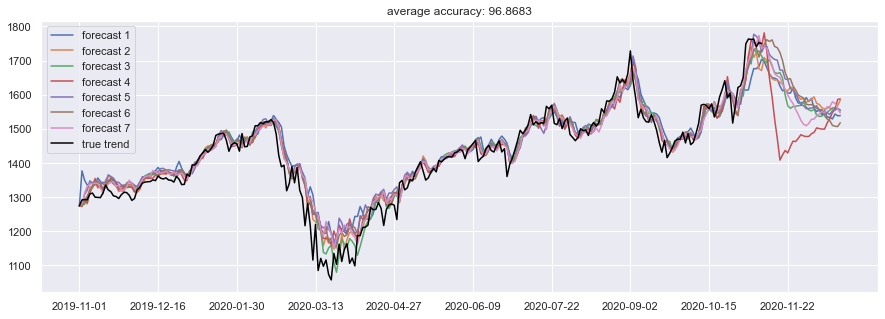

In [49]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30])

plt.show()